In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from typing import Tuple
import torch
from torch import nn
from torch import Tensor
from tqdm import trange
from tqdm.contrib.logging import logging_redirect_tqdm
import logging
from datetime import datetime
from torchmetrics import MeanSquaredError

from AGG.extended_typing import ContinuousTimeGraphSample
from AGG.graph_dataset import GraphDataset
from AGG.utils import FeedForward
from AGG.utils import Time2Vec
from AGG.transformer_model import SelfAttentionBlock, CrossAttentionBlock
from torch.utils.data import DataLoader
from AGG.extended_typing import collate_graph_samples
from Datasets.data_tools import random_index

%matplotlib inline

In [4]:
LOG = logging.getLogger(__name__)

logging.basicConfig(level=logging.INFO)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
experiment = datetime.now().strftime("%d-%m_%H:%M:%S")
print(f'Log for {experiment=}')


class AGG(nn.Module):
    def __init__(self,
                 input_dim: int,
                 feature_dim: int,
                 num_heads: int,
                 time_embedding_dim: int,
                 num_layers: int,
                 attention_drop: float = 0.2,
                 dropout: float = 0.2,
                 ):
        super().__init__()
        self.feature_projection = nn.Linear(input_dim, feature_dim)
        self.node_feature_dim = feature_dim + time_embedding_dim
        self.query_dim = time_embedding_dim
        self.time_embed = Time2Vec(time_embedding_dim)
        self.agg_layers = nn.ModuleList()
        for i in range(num_layers):
            self.agg_layers.append(
                SelfAttentionBlock(
                    embed_dim=self.node_feature_dim,
                    num_heads=num_heads,
                    dropout=attention_drop,
                    batch_first=True,
                )
            )
        self.cross_attention = CrossAttentionBlock(
            target_dim=self.query_dim,
            source_dim=self.node_feature_dim,
            num_heads=num_heads,
            dropout=attention_drop,
        )
        self.head = FeedForward(
            input_size=self.query_dim,
            hidden_dim=self.query_dim * num_heads,
            output_size=input_dim,
            dropout=dropout,
        )

    def forward(self, graph: ContinuousTimeGraphSample, device: torch.device = "cpu") -> Tuple[Tensor, list]:
        features = self.feature_projection(graph.node_features.unsqueeze(-1).to(device))
        time_encode = self.time_embed(graph.time.unsqueeze(-1).to(device))
        source_list = [features, time_encode]
        source = torch.cat(
            source_list,
            dim=-1,
        )
        query_list = [
            self.time_embed(graph.target.time.unsqueeze(-1).to(device)),
        ]
        target = torch.cat(
            query_list,
            dim=-1,
        )
        key_padding_mask = graph.key_padding_mask.to(device)
        attn_mask = graph.attention_mask.to(device)
        hidden = source
        if torch.any(torch.isnan(source)):
            print(source)
        if torch.any(torch.isnan(target)):
            print(target)
        total_attention = []
        for agg_layer in self.agg_layers:
            hidden, attention_weights = agg_layer(hidden, attn_mask, key_padding_mask)
            total_attention.append(attention_weights)
        y_hat, attention_weights = self.cross_attention(
            target, hidden, key_padding_mask
        )
        total_attention.append(attention_weights)
        y_hat = self.head(y_hat)
        y_hat = y_hat.squeeze(-1)
        return y_hat, total_attention


class SinusoidDataset(GraphDataset):
    def __init__(self, context_length: int | None = None):
        fs = 1000
        t = np.arange(0, 10, 1 / fs)
        f = 10
        x = np.sin(2 * np.pi * f * t)
        self.x = x
        self.t = t
        removed, remainder = random_index(x.shape[0], 0.95)
        self.training_samples = x[remainder]
        self.training_samples_t = t[remainder]
        _, target_index = random_index(removed.shape[0], 0.95)
        self.target_samples = x[removed[target_index]]
        self.target_samples_t = t[removed[target_index]]
        if context_length is None:
            context_length = self.training_samples.shape[0]
        self.dataset = self.generate_data(context_length)

    def generate_data(self, context_length: int) -> list:
        graph_dataset = []
        for i in trange(0, self.training_samples.shape[0] - context_length + 1):
            time = self.training_samples_t[i: i + context_length]
            tau = time
            target_times = self.target_samples_t[
                (self.target_samples_t >= time[0])
                & (self.target_samples_t <= time[-1])
                ]
            target_samples_masked = self.target_samples[
                (self.target_samples_t >= time[0])
                & (self.target_samples_t <= time[-1])
                ]
            for j in trange(target_times.shape[0]):
                target_time = target_times[j]
                graph_dataset.append({
                    "node_features": self.training_samples[i: i + context_length].tolist(),
                    "time": tau.tolist(),
                    'key_padding_mask': (
                            np.zeros_like(time) != 0
                        ).tolist(),
                    "target": {
                        "features": [target_samples_masked[j].tolist(), ],
                        "time": [target_time.tolist(), ],
                    }
                })
        return graph_dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> ContinuousTimeGraphSample:
        graph = self.graph_transform(self.dataset[idx])
        return graph


model = AGG(
    input_dim=1,
    feature_dim=4,
    num_heads=2,
    time_embedding_dim=4,
    num_layers=1,
    attention_drop=0.0,
    dropout=0.0,
)
sinusoid_dataset = SinusoidDataset(context_length=100)

sinusoid_train_dataloader = DataLoader(
    sinusoid_dataset,
    batch_size=100,
    shuffle=True,
    drop_last=False,
    num_workers=8,
    collate_fn=collate_graph_samples,
)

sinusoid_val_dataloader = DataLoader(
    sinusoid_dataset,
    batch_size=100,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    collate_fn=collate_graph_samples,
)
print(f"Number of training samples: {len(sinusoid_dataset)}")
print(f"Model summary: {model}")
model = model.to(device)

Using device cuda:0
Log for experiment='06-01_15:34:42'


100%|██████████| 101/101 [00:00<00:00, 78492.63it/s]

100%|██████████| 101/101 [00:00<00:00, 83079.96it/s]

100%|██████████| 104/104 [00:00<00:00, 82194.76it/s]

100%|██████████| 103/103 [00:00<00:00, 27427.68it/s]

100%|██████████| 103/103 [00:00<00:00, 69634.64it/s]

100%|██████████| 102/102 [00:00<00:00, 76232.90it/s]

100%|██████████| 103/103 [00:00<00:00, 85564.13it/s]

100%|██████████| 100/100 [00:00<00:00, 86569.74it/s]

100%|██████████| 100/100 [00:00<00:00, 86107.66it/s]

100%|██████████| 100/100 [00:00<00:00, 83986.86it/s]

100%|██████████| 101/101 [00:00<00:00, 87309.30it/s]

100%|██████████| 101/101 [00:00<00:00, 85580.75it/s]

100%|██████████| 100/100 [00:00<00:00, 81664.80it/s]

100%|██████████| 98/98 [00:00<00:00, 51201.02it/s]

100%|██████████| 98/98 [00:00<00:00, 36401.15it/s]

100%|██████████| 98/98 [00:00<00:00, 14731.10it/s]

100%|██████████| 96/96 [00:00<00:00, 36307.77it/s]

100%|██████████| 97/97 [00:00<00:00, 36449.34it/s]

100%|██████████| 95/95 [00:00<00:00, 3

Number of training samples: 37965
Model summary: AGG(
  (feature_projection): Linear(in_features=1, out_features=4, bias=True)
  (time_embed): Time2Vec(
    (linear): Linear(in_features=1, out_features=4, bias=True)
  )
  (agg_layers): ModuleList(
    (0): SelfAttentionBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (feed_forward): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=8, out_features=16, bias=True)
          (1): LeakyReLU(negative_slope=0.2)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=16, out_features=8, bias=True)
        )
      )
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    )
  )
  (cross_attention): CrossAttentionBlock(
    (norm1_source): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm1_target): 

In [5]:
mse_loss = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_RMSE = MeanSquaredError(squared=False).to(device)
val_RMSE = MeanSquaredError(squared=False).to(device)
epochs = 1000
total_train = np.inf
total_val = np.inf
lowest_loss = np.inf
with logging_redirect_tqdm():
    prog_bar = trange(epochs, leave=True)
    for epoch in prog_bar:
        model.train()
        for graph_samples in sinusoid_train_dataloader:
            y_hat, total_attention = model(graph_samples, device)
            loss = mse_loss(y_hat, graph_samples.target.features.to(device))
            rmse = train_RMSE(y_hat, graph_samples.target.features.to(device))
            optimiser.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimiser.step()
            prog_bar.set_description(f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)

        with torch.no_grad():
            total_train = train_RMSE.compute()
            prog_bar.set_description(f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}", refresh=True)
            model.eval()
            for graph_samples in sinusoid_val_dataloader:
                y_hat, total_attention = model(graph_samples, device)
                loss = mse_loss(y_hat, graph_samples.target.features.to(device))
                rmse = val_RMSE(y_hat, graph_samples.target.features.to(device))
            total_val = val_RMSE.compute()
            prog_bar.set_description(f"current loss: {loss.item()}, train_rmse {total_train:.4f}, val_rmse {total_val:.4f}",
                                     refresh=True)
            if total_val < lowest_loss:
                torch.save(
                    model.state_dict(), f"./best_model_{experiment}.mdl"
                )
                lowest_loss = total_val

current loss: 0.5041157603263855, train_rmse 0.6925, val_rmse inf:   0%|          | 0/1000 [00:06<?, ?it/s]/home/chris/miniconda3/envs/GNN/lib/python3.11/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
current loss: 0.37108710408210754, train_rmse 0.6603, val_rmse 0.6582: 100%|██████████| 1000/1000 [3:14:29<00:00, 11.67s/it] 


In [6]:
model.load_state_dict(torch.load(f"best_model_{experiment}.mdl"))
predictions = []
predict_time = []
with torch.no_grad():
    model.eval()
    for graph_samples in sinusoid_val_dataloader:
        y_hat, total_attention = model(graph_samples, device)
        predictions += y_hat.flatten().tolist()
        predict_time += graph_samples.target.time.flatten().tolist()
input = graph_samples.node_features.flatten().tolist()
input_t = graph_samples.time.flatten().tolist()

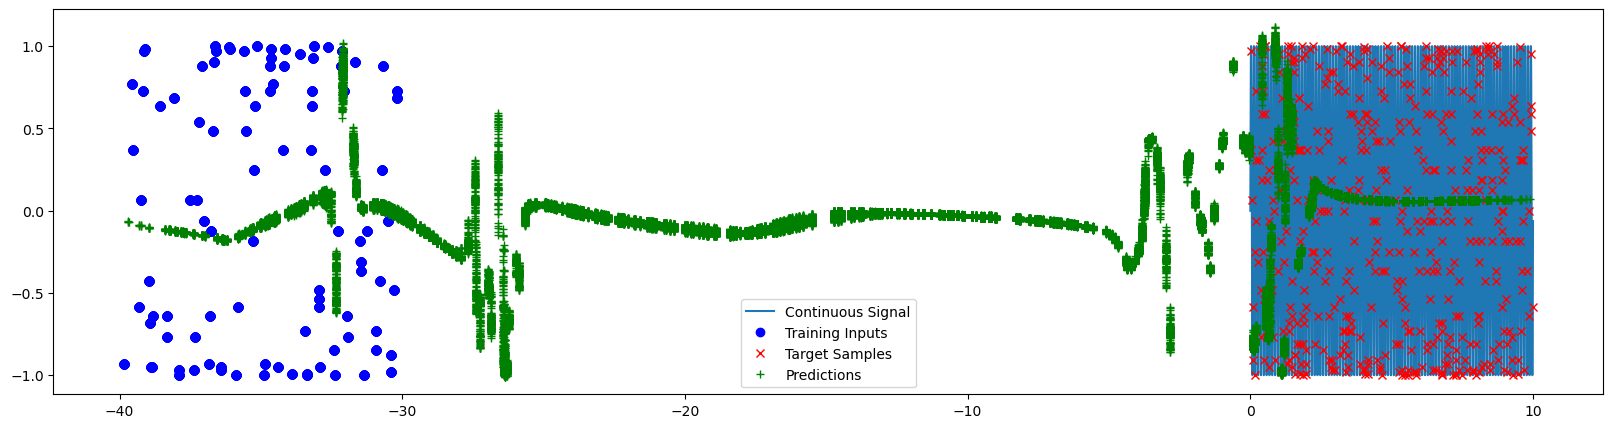

In [7]:
plt.figure(figsize=(20, 5))

shifted_t_input = sinusoid_dataset.t.max() - np.array(input_t)*5.0
shifted_t_predict = sinusoid_dataset.t.max() - np.array(predict_time)*5.0
plt.plot(sinusoid_dataset.t, sinusoid_dataset.x, label="Continuous Signal")
plt.plot(shifted_t_input, np.array(input), 'bo', label="Training Inputs")
plt.plot(sinusoid_dataset.target_samples_t, sinusoid_dataset.target_samples, 'rx', label="Target Samples")
plt.plot(shifted_t_predict, np.array(predictions), 'g+', label="Predictions")
plt.legend()
plt.show()

In [8]:
model.time_embed.linear.weight/(torch.pi*2)

tensor([[ 0.0371],
        [-0.0937],
        [-0.0079],
        [ 0.0131]], device='cuda:0', grad_fn=<DivBackward0>)

In [9]:
model.time_embed.linear.bias

Parameter containing:
tensor([-0.9878,  1.0828,  0.0804,  0.0977], device='cuda:0',
       requires_grad=True)

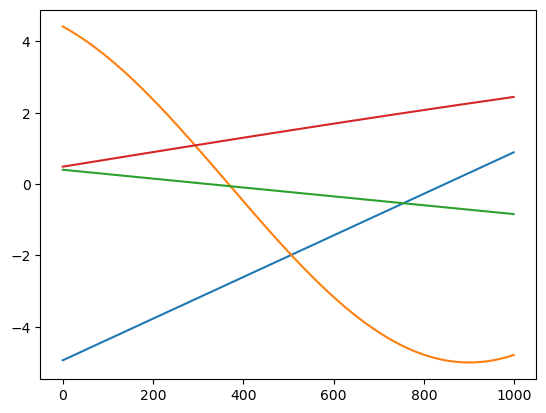

In [10]:
t = torch.linspace(0, 5, 1000).to(device)
t = t.unsqueeze(-1)
tau = model.time_embed(t)*5.0
plt.plot(tau.detach().cpu().numpy())
plt.show()